In [1]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from pprint import pprint

from libs import run_model, calculate_doubling_time, plot_exponential_growth, analyze_agi_arrival
from params import start_task_length, agi_task_length, doubling_time, acceleration, shift


O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)

print('Loaded libraries')

## START task length (displayed in min) ##
{1: 0.02,
 5: 0.02,
 10: 0.03,
 20: 0.1,
 30: 0.24,
 40: 0.52,
 50: 1.03,
 60: 2.01,
 70: 4.02,
 80: 8.39,
 90: 24.18,
 95: 53.23,
 99: 226.51}



## AGI task length (displayed in hrs) ##
{1: 40,
 5: 51,
 10: 80,
 20: 138,
 30: 206,
 40: 290,
 50: 397,
 60: 545,
 70: 765,
 80: 1148,
 90: 1996,
 95: 3148,
 99: 7393}



## DOUBLING TIME (displayed in days) ##
{1: 115,
 5: 118,
 10: 118,
 20: 148,
 30: 166,
 40: 181,
 50: 199,
 60: 212,
 70: 212,
 80: 212,
 90: 222,
 95: 243,
 99: 285}



## ACCELERATION (displayed in days)
{1: 0.898,
 5: 0.978,
 10: 1.0,
 20: 1.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.001,
 95: 1.023,
 99: 1.1}



## SHIFT (displayed in days) ##
{1: 0,
 5: 30,
 10: 56,
 20: 89,
 30: 112,
 40: 132,
 50: 150,
 60: 169,
 70: 189,
 80: 211,
 90: 244,
 95: 271,
 99: 320}
Loaded libraries


In [2]:
def adapted_metr_model():
    start_task_length_ = start_task_length * (2 ** (shift / doubling_time))
    days = calculate_doubling_time(start_task_length_, agi_task_length, doubling_time, acceleration)
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

samples = run_model(adapted_metr_model, index_date=O3_LAUNCH_DATE, cores=4)

Generating samples with 4 cores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:21<00:00, 4704.76it/s]


Shuffling data...
Waiting for other cores...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 903.94it/s]


...Collected!
{1: 804,
 5: 1214,
 10: 1475,
 20: 1831,
 30: 2135,
 40: 2418,
 50: 2705,
 60: 3013,
 70: 3355,
 80: 3778,
 90: 4447,
 95: 5038,
 99: 6333}

-

{1: '2027 Jun 28',
 5: '2028 Aug 12',
 10: '2029 Apr 30',
 20: '2030 Apr 21',
 30: '2031 Feb 20',
 40: '2031 Nov 30',
 50: '2032 Sep 12',
 60: '2033 Jul 16',
 70: '2034 Jun 24',
 80: '2035 Aug 20',
 90: '2037 Jun 19',
 95: '2039 Feb 01',
 99: '2042 Aug 19'}


In [3]:
analyze_agi_arrival(samples)

## DISTRIBUTION OF AGI ARRIVAL DATE ##
1%: 2027.2
2%: 2027.6
3%: 2027.9
4%: 2028.1
5%: 2028.3
10%: 2029.0
15%: 2029.6
20%: 2030.0
25%: 2030.4
35%: 2031.2
50%: 2032.4
60%: 2033.3
75%: 2034.7
80%: 2035.3
90%: 2037.2
95%: 2038.8


## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##
1%: 2.2 years from now
2%: 2.6 years from now
3%: 2.9 years from now
4%: 3.1 years from now
5%: 3.3 years from now
10%: 4.0 years from now
15%: 4.6 years from now
20%: 5.0 years from now
25%: 5.4 years from now
35%: 6.2 years from now
50%: 7.4 years from now
60%: 8.3 years from now
75%: 9.7 years from now
80%: 10.3 years from now
90%: 12.2 years from now
95%: 13.8 years from now
(Mean: 8 years from now)


## AGI ARRIVAL DATE BY BIN ##
2025: 0.1%
2026: 0.6%
2027: 2.7%
2028: 6.3%
2029: 10.1%
2030-2031: 24.9%
2032-2034: 32.5%
2035-2039: 19.8%
2040-2049: 2.9%
2050-2059: 0.0%
2060-2069: 0.0%
2070-2079: 0.0%
2080-2089: 0.0%
2090-2099: 0.0%
>2100: 0.0%


## AGI ARRIVAL DATE BY YEAR ##
By EOY 2025: 0.1%
By EOY 2026: 0.7%
B

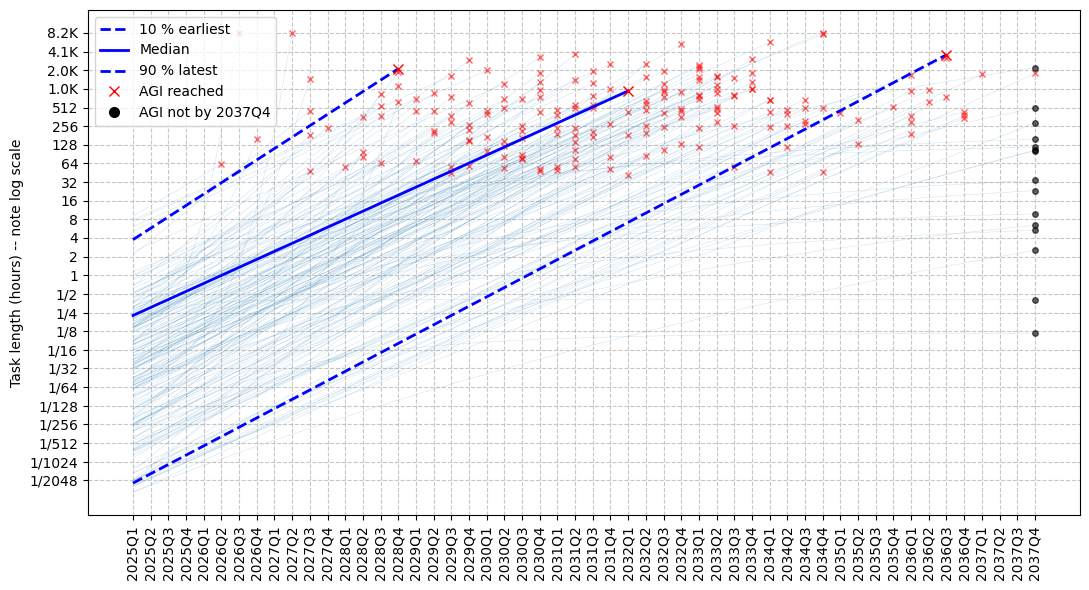

In [4]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=start_task_length,
    agi_task_length=agi_task_length,
    shift=shift,
    acceleration=acceleration,
    n_quarters=51,
    n_samples=100_000,
    n_traces=200,
    max_task_power=13,
    min_y_power=-15,
)